In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load the dataset
file_path = '/content/Battery_1_Features.csv'
data = pd.read_csv(file_path)

# Select all features except for the index column
feature_columns = data.columns[1:]  # Excluding the 'Cycle_Index' column
selected_data = data[feature_columns].values

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(selected_data)

In [ ]:
# Function to add Gaussian noise
def add_gaussian_noise(image, noise_level=0.02):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

# Apply FFT to each feature column and normalize
fft_images = []
N = 44  # Reduce image size to 44

In [ ]:
for feature_idx in range(normalized_data.shape[1]):
    feature_data = normalized_data[:, feature_idx]
    fft_feature_data = np.fft.fft(feature_data)
    normalized_fft = np.abs(fft_feature_data) / np.max(np.abs(fft_feature_data))
    fft_image = np.resize(normalized_fft, (N, N))
    fft_images.append(fft_image)

# Stack all FFT images to create a multi-channel image
fft_image_stack = np.stack(fft_images, axis=-1)

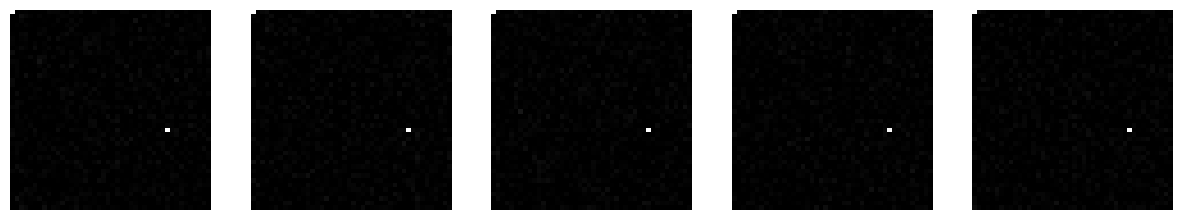

In [ ]:
# Generate multiple samples by adding Gaussian noise
num_samples = len(normalized_data)
noisy_images_stack = [add_gaussian_noise(fft_image_stack) for _ in range(num_samples)]
noisy_images_stack = np.array(noisy_images_stack)

# Display a few examples of the noisy images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(noisy_images_stack[i][:, :, 0], cmap='gray')  # Displaying the first channel
    ax.axis('off')
plt.show()

In [ ]:
# DCGAN Model Definition
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 11 * 11, activation="relu", input_dim=100))
    model.add(Reshape((11, 11, 128)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(50, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    noise = Input(shape=(100,))
    img = model(noise)
    return Model(noise, img)

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(44, 44, 50), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))  # Increase dropout rate
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))  # Increase dropout rate
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))  # Increase dropout rate
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    img = Input(shape=(44, 44, 50))
    validity = model(img)
    return Model(img, validity)

In [ ]:
# Function to train the DCGAN
def train_dcgan(epochs, batch_size=32, save_interval=50):
    X_train = noisy_images_stack
    X_train = (X_train - 0.5) / 0.5

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for _ in range(1):  # Train the discriminator less frequently
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, 100))
            gen_imgs = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = combined.train_on_batch(noise, valid)

        # Check discriminator accuracy
        d_acc = 100 * d_loss[1]
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {d_acc}%] [G loss: {g_loss}]")

        # Stop training if discriminator accuracy is around 50% and D loss and G loss are ideal
        if 45 <= d_acc <= 55 and 0.6 <= d_loss[0] <= 1.2 and g_loss < 1:
            print(f"Stopping training at epoch {epoch} as all conditions are met: D acc: {d_acc}%, D loss: {d_loss[0]}, G loss: {g_loss}.")
            break

    # Clear memory after training
    del X_train, valid, fake
    gc.collect()
    tf.keras.backend.clear_session()

In [ ]:
# Optimizer
optimizer_gen = Adam(0.0004, 0.5)  # Increased learning rate for the generator
optimizer_disc = Adam(0.0001, 0.5)  # Reduced learning rate for the discriminator

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates images
z = Input(shape=(100,))
img = generator(z)

# For the combined model, we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model (stacked generator and discriminator)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer_gen)

# Train the DCGAN
train_dcgan(epochs=10000, batch_size=32, save_interval=50)

1/1 [==============================] - 0s 112ms/step


0 [D loss: 1.0313640832901, acc.: 48.4375%] [G loss: 0.5285111665725708]
Stopping training at epoch 0 as all conditions are met: D acc: 48.4375%, D loss: 1.0313640832901, G loss: 0.5285111665725708.


In [ ]:
# Memory management: clear unnecessary variables and invoke garbage collection
del fft_images, fft_image_stack, noisy_images_stack
gc.collect()
tf.keras.backend.clear_session()

In [ ]:
# Rebuild models to generate synthetic data without training overhead
discriminator = build_discriminator()
generator = build_generator()

In [ ]:
# Function to generate and save synthetic data in batches
def inverse_fft_image(image):
    channels = []
    for i in range(image.shape[-1]):
        channel = image[:, :, i]
        channel = channel.flatten()
        ifft_data = np.fft.ifft(channel)
        channels.append(ifft_data.real)
    return np.stack(channels, axis=-1)

In [ ]:
def generate_and_save_synthetic_data(batch_size=32, output_file='synthetic_data.csv'):
    num_batches = int(np.ceil(num_samples / batch_size))
    synthetic_data_list = []

    for i in range(num_batches):
        batch_noise = np.random.normal(0, 1, (min(batch_size, num_samples - i * batch_size), 100))
        batch_gen_imgs = generator.predict(batch_noise)
        batch_gen_imgs_rescaled = 0.5 * batch_gen_imgs + 0.5

        # Convert generated images back to original feature space
        batch_synthetic_data = np.array([inverse_fft_image(img) for img in batch_gen_imgs_rescaled])

        # Debugging: Print shapes to verify dimensions
        print(f"Batch {i+1}/{num_batches}")
        print(f"  batch_gen_imgs shape: {batch_gen_imgs.shape}")
        print(f"  batch_synthetic_data shape: {batch_synthetic_data.shape}")

        # Flatten each channel back to its original number of features
        batch_synthetic_data_reshaped = batch_synthetic_data.reshape(batch_synthetic_data.shape[0], -1)

        # Debugging: Print shape after reshaping
        print(f"  batch_synthetic_data_reshaped shape: {batch_synthetic_data_reshaped.shape}")

        # Append to the list
        synthetic_data_list.append(batch_synthetic_data_reshaped)

        # Clear memory after each batch
        del batch_noise, batch_gen_imgs, batch_gen_imgs_rescaled, batch_synthetic_data, batch_synthetic_data_reshaped
        gc.collect()

    # Concatenate all batches
    synthetic_data = np.vstack(synthetic_data_list)

    # Reshape to original feature space dimensions before applying inverse transform
    num_features = len(feature_columns)
    synthetic_data = synthetic_data.reshape(-1, num_features)

    # Rescale synthetic data back to original scale
    synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)

    # Save synthetic data to a CSV file
    synthetic_data_df = pd.DataFrame(synthetic_data_rescaled, columns=feature_columns)
    synthetic_data_df.to_csv(output_file, index=False)

In [ ]:
# Generate and save synthetic data
generate_and_save_synthetic_data(batch_size=32, output_file='synthetic_data.csv')

1/1 [==============================] - 0s 244ms/step
Batch 1/37
  batch_gen_imgs shape: (32, 44, 44, 50)
  batch_synthetic_data shape: (32, 1936, 50)
  batch_synthetic_data_reshaped shape: (32, 96800)
1/1 [==============================] - 0s 19ms/step
Batch 2/37
  batch_gen_imgs shape: (32, 44, 44, 50)
  batch_synthetic_data shape: (32, 1936, 50)
  batch_synthetic_data_reshaped shape: (32, 96800)
1/1 [==============================] - 0s 16ms/step
Batch 3/37
  batch_gen_imgs shape: (32, 44, 44, 50)
  batch_synthetic_data shape: (32, 1936, 50)
  batch_synthetic_data_reshaped shape: (32, 96800)
1/1 [==============================] - 0s 20ms/step
Batch 4/37
  batch_gen_imgs shape: (32, 44, 44, 50)
  batch_synthetic_data shape: (32, 1936, 50)
  batch_synthetic_data_reshaped shape: (32, 96800)
1/1 [==============================] - 0s 17ms/step
Batch 5/37
  batch_gen_imgs shape: (32, 44, 44, 50)
  batch_synthetic_data shape: (32, 1936, 50)
  batch_synthetic_data_reshaped shape: (32, 96800)

1/1 [==============================] - 1s 766ms/step


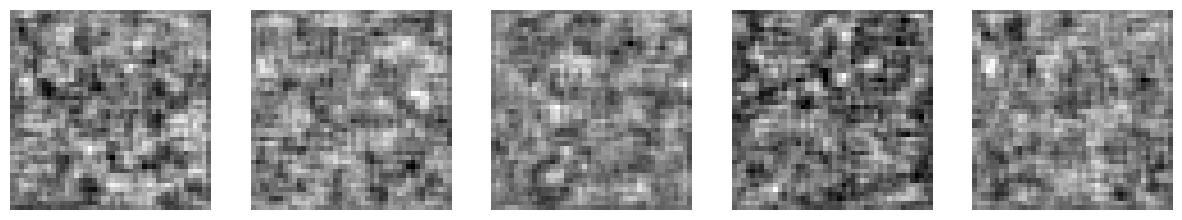

In [ ]:
# Display a few synthetic samples
num_display = 5
noise = np.random.normal(0, 1, (num_display, 100))
gen_imgs = generator.predict(noise)
fig, axes = plt.subplots(1, num_display, figsize=(15, 3))
for i in range(num_display):
    axes[i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
    axes[i].axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load synthetic dataset
synthetic_data = pd.read_csv('/content/synthetic_data.csv')

In [ ]:
# Select a subset of features for comparison
features_to_compare = data.columns[1:6]  # Example: first 5 features

# Normalize real and synthetic data for comparison
scaler = MinMaxScaler()
real_data_normalized = scaler.fit_transform(data[features_to_compare])
synthetic_data_normalized = scaler.transform(synthetic_data[features_to_compare])

In [ ]:
# Convert to DataFrame for easier plotting
real_data_normalized = pd.DataFrame(real_data_normalized, columns=features_to_compare)
synthetic_data_normalized = pd.DataFrame(synthetic_data_normalized, columns=features_to_compare)

In [ ]:
# Plot histograms to compare real and synthetic data distributions
def plot_histograms(data, synthetic_data, features, bins=50):
    fig, axes = plt.subplots(nrows=len(features), ncols=2, figsize=(14, 3 * len(features)))
    fig.suptitle('Comparison of Real and Synthetic Data Distributions', fontsize=16)

    for i, feature in enumerate(features):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        sns.histplot(data[feature], bins=bins, kde=True, ax=ax1, color='blue')
        ax1.set_title(f'Real Data: {feature}')

        sns.histplot(synthetic_data[feature], bins=bins, kde=True, ax=ax2, color='green')
        ax2.set_title(f'Synthetic Data: {feature}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
# Plot CDFs to compare real and synthetic data distributions
def plot_cdfs(data, synthetic_data, features):
    fig, ax = plt.subplots(figsize=(10, 6))

    for feature in features:
        real_sorted = np.sort(data[feature])
        synthetic_sorted = np.sort(synthetic_data[feature])
        p_real = 1. * np.arange(len(real_sorted)) / (len(real_sorted) - 1)
        p_synthetic = 1. * np.arange(len(synthetic_sorted)) / (len(synthetic_sorted) - 1)

        ax.plot(real_sorted, p_real, label=f'Real {feature}', linestyle='--')
        ax.plot(synthetic_sorted, p_synthetic, label=f'Synthetic {feature}', linestyle='-')

    ax.set_title('Cumulative Distribution Functions (CDFs)')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.legend()
    plt.show()

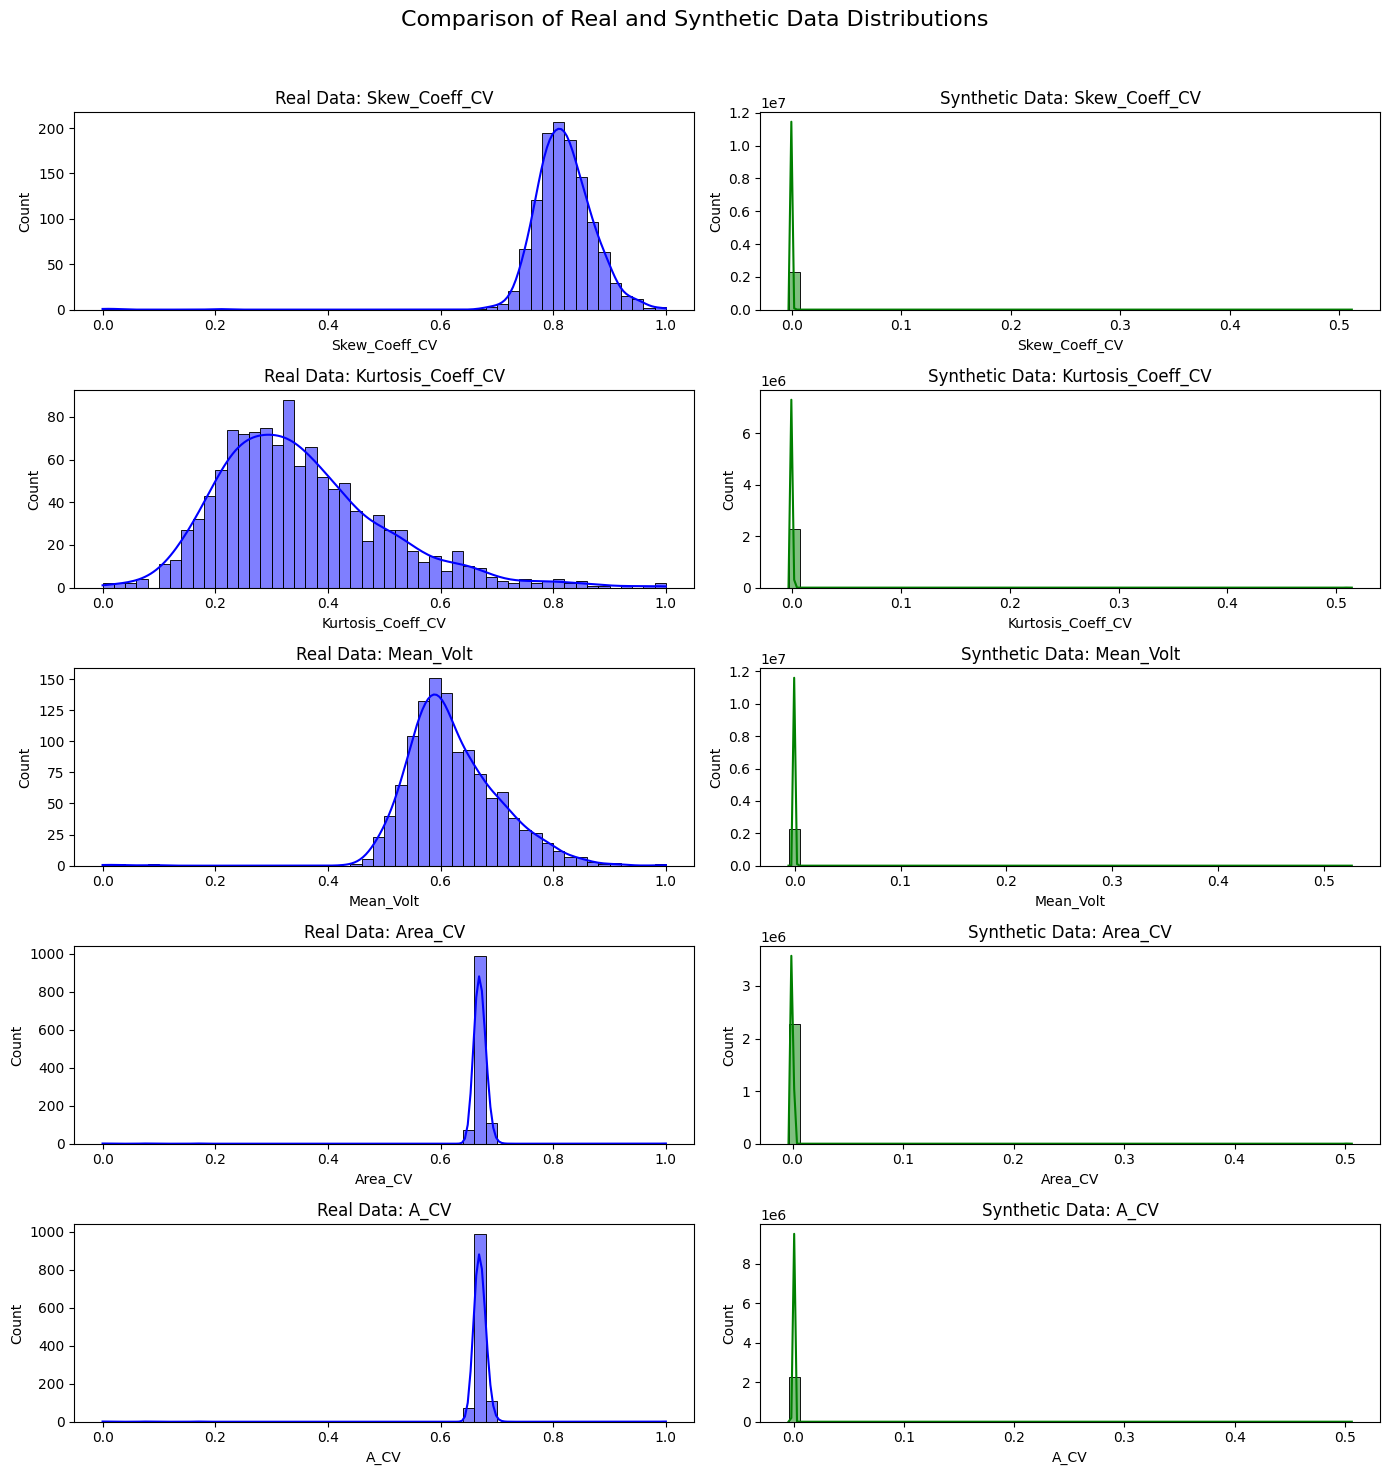

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


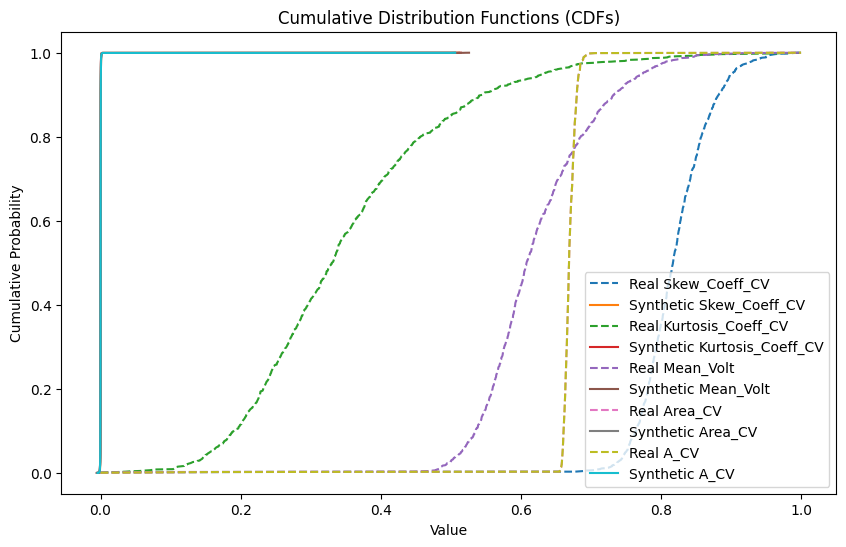

In [ ]:
# Compare real and synthetic data distributions for selected features
plot_histograms(real_data_normalized, synthetic_data_normalized, features_to_compare)
plot_cdfs(real_data_normalized, synthetic_data_normalized, features_to_compare)